<a href="https://colab.research.google.com/github/ghgh415263/Mal_dectection/blob/main/model_VGG16_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/data/malimg_dataset.zip" -d "/content/dataset"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg16 import VGG16

import pathlib

class CustomCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
        current_decayed_lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print("current decayed lr: {:0.7f}".format(current_decayed_lr))

DATA_PATH = "/content/dataset"
batch_size = 128
img_height = 224
img_width = 224
val_split = 0.2
interpolation = 'bicubic' #bicubic bilinear

data_dir = pathlib.Path(DATA_PATH)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  color_mode='rgb',
  interpolation=interpolation,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  color_mode='rgb',
  interpolation=interpolation,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3))
#base_model.trainable=False

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    #keras.layers.Dropout(0.5),
    layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),
    layers.Flatten(),
    layers.Dense(25, activation='softmax')
])

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2340,
    decay_rate=0.5,
    staircase=False) #staircase=False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

checkpoint_path = "/content/drive/MyDrive/Colab_Notebooks/save/ft(0.00001,nodrop)-vgg16-1layer(drop 0.15)-bicubic,decay(0.6),maxp/cp-{epoch:04d}.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

#latest = tf.train.latest_checkpoint("/content/drive/MyDrive/Colab_Notebooks/save/vgg16-1layer(drop 0.15)-bicubic,decay(0.6),maxp")
model.load_weights("/content/drive/MyDrive/Colab_Notebooks/save/vgg16-1layer(drop 0.15)-bicubic,decay(0.6),maxp/cp-0098.ckpt")

'''def scheduler(epoch, lr):
  if epoch > 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)'''

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=50)

history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=[cp_callback])

39/59 [==================>...........] - ETA: 17s - loss: 1.8019e-04 - accuracy: 1.0000

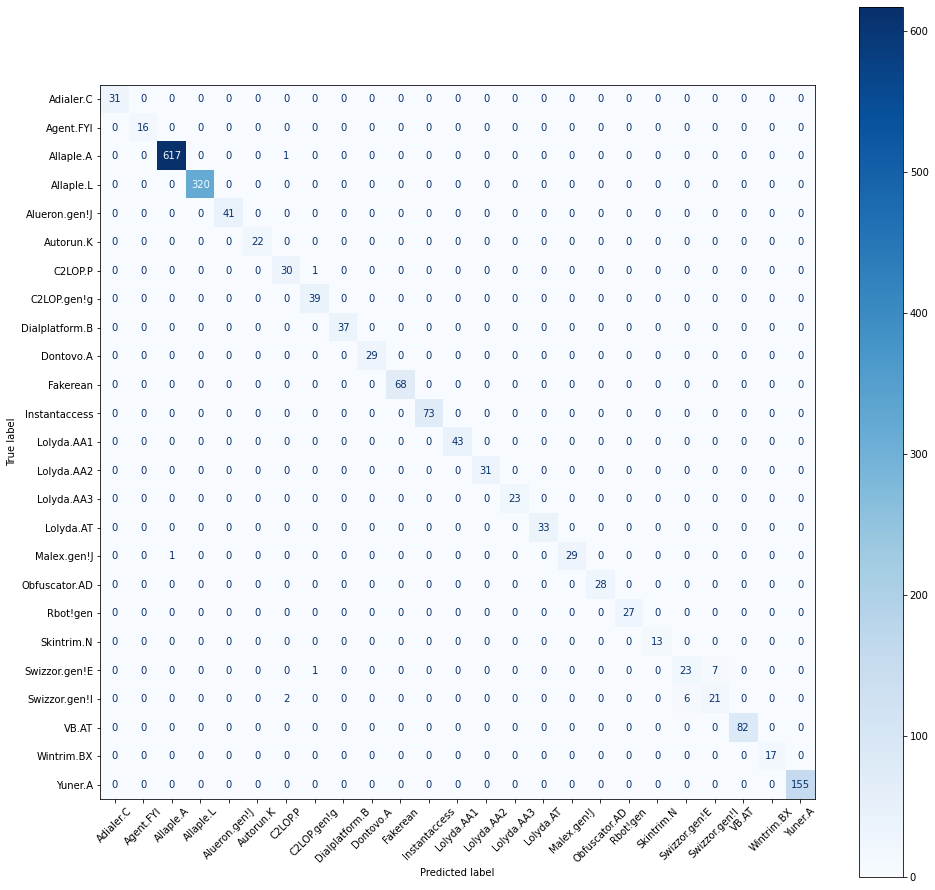

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_test = np.array([])
y_pred = np.array([])

for x,y in val_ds:
  y_test = np.append(y_test, y.numpy(), axis=0)
  tmp = (model.predict(x)).argmax(axis=-1)
  y_pred = np.append(y_pred, tmp, axis=0)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
fig, ax = plt.subplots(figsize=(16,16))

disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.show()

In [ ]:
rm -r "/content/drive/MyDrive/Colab_Notebooks/save/training-vgg16-1layer-bilinear,bicubic"

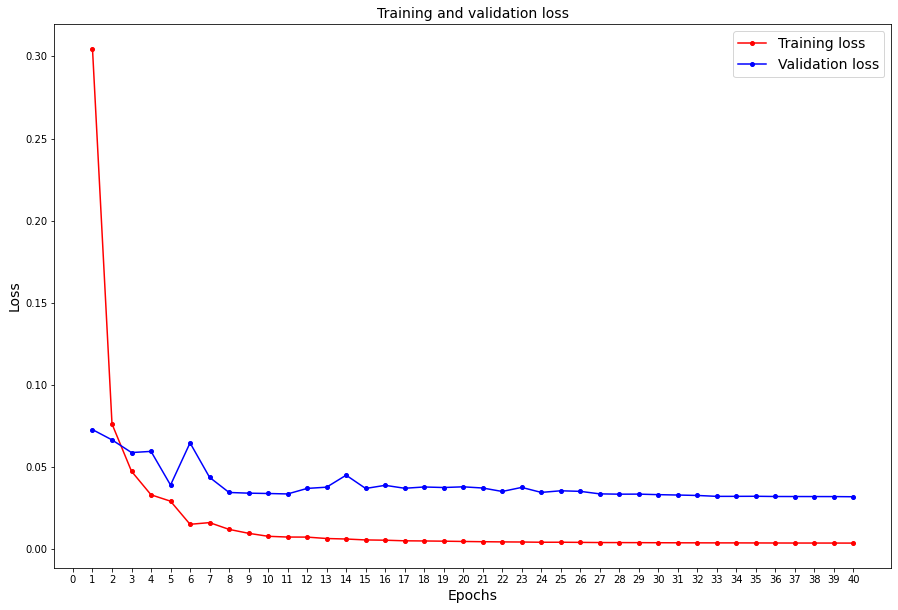

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'ro-', label='Training loss', markersize = 4)
plt.plot(epochs, val_loss, 'bo-', label='Validation loss', markersize = 4)
plt.title('Training and validation loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(len(acc) + 1), range(len(acc) + 1))

plt.show()

<Figure size 432x288 with 0 Axes>

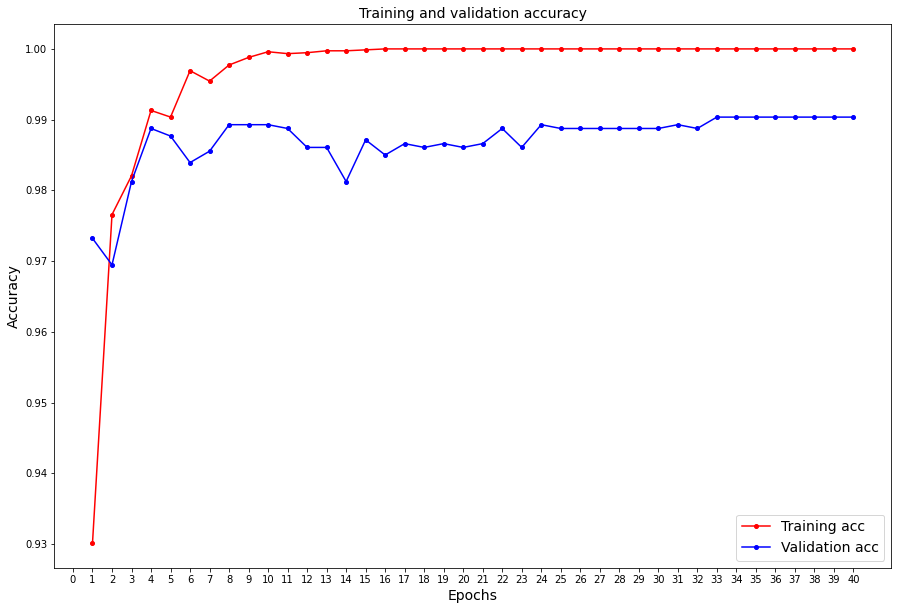

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'ro-', label='Training acc', markersize = 4)
plt.plot(epochs, val_acc, 'bo-', label='Validation acc', markersize = 4)
plt.title('Training and validation accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(len(acc) + 1), range(len(acc) + 1))

plt.show()

In [ ]:
print("%-8s" % "epoch", "%-23s" % "train_loss", "%-23s" % "val_loss", "%-23s" % "train_acc", "%-23s" % "val_acc")
print("=" * 99)
for i in range(1,len(acc)+1):
        print("%-8s" %i, "%-23s" % loss[i-1], "%-23s" % val_loss[i-1], "%-23s" % acc[i-1], "%-23s" % val_acc[i-1])

epoch    train_loss              val_loss                train_acc               val_acc                
1        0.3045744001865387      0.07270529121160507     0.9301391839981079      0.973219096660614      
2        0.07615350186824799     0.06644077599048615     0.9765792489051819      0.9694697260856628     
3        0.04732786491513252     0.05872950702905655     0.9820663928985596      0.9812533259391785     
4        0.03299803286790848     0.05943535640835762     0.9913008809089661      0.988752007484436      
5        0.02910643257200718     0.03893159702420235     0.9903640151023865      0.9876807928085327     
6        0.015032589435577393    0.06462732702493668     0.9969218373298645      0.9839314222335815     
7        0.016056180000305176    0.0436391681432724      0.9954496622085571      0.9855383038520813     
8        0.01193910837173462     0.034422263503074646    0.9977248311042786      0.9892876148223877     
9        0.009546302258968353    0.033998262137174606  